Stochastic Gradient Descent. 
Init weights. Predict. Calculate loss.
Calculate gradient. 
Step, change the weights. 
Repeat. 

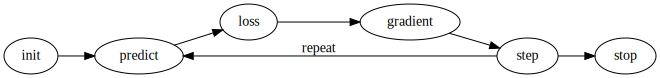

In [11]:
from fastbook import *
gv('''
init->predict->loss->gradient->step->stop
step->predict[label=repeat]
''')


Illustrating a loss function

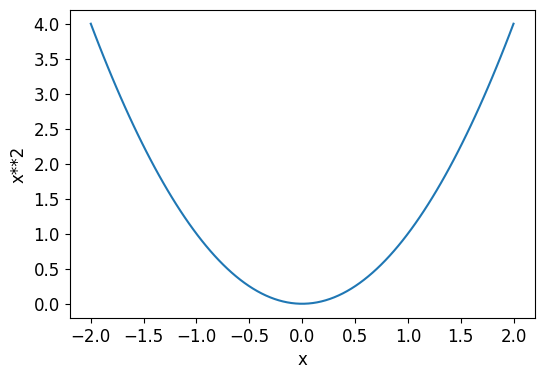

In [12]:
def f(x): return x**2
plot_function(f, 'x', 'x**2')

Pick random value for a starting parameter and calculate value of the loss. 

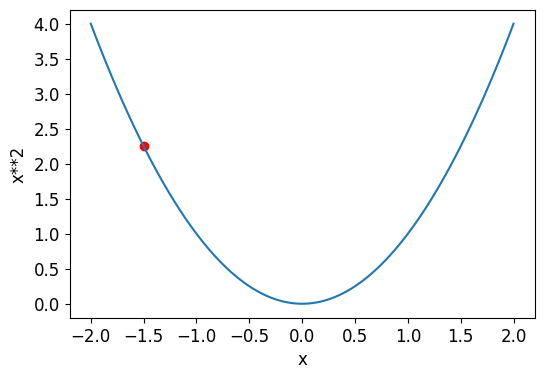

In [13]:
plot_function(f, 'x', 'x**2')
plt.scatter(-1.5, f(-1.5), color='red')

Calculating gradients. 
Pick a tensor value which we want gradients at. 

In [14]:
xt = tensor(3.).requires_grad_()
xt

tensor(3., requires_grad=True)

In [15]:
yt = f(xt)
yt

tensor(9., grad_fn=<PowBackward0>)

In [16]:
# Backpropagation, to calculate the derivative of each layer. Calculate the gradient. 
yt.backward()

In [17]:
xt.grad

tensor(6.)

Repeat the same but with a vector


In [18]:
xt = tensor([3., 4., 10.]).requires_grad_()
xt

tensor([ 3.,  4., 10.], requires_grad=True)

In [19]:
def f(x): return (x**2).sum()

yt = f(xt)
yt

tensor(125., grad_fn=<SumBackward0>)

In [20]:
yt.backward()
xt.grad

tensor([ 6.,  8., 20.])

Stepping with a learning rate